# Deep Sets Tutorial

We were motivated to try Deep Sets ATLAS FTAG from the lovely "Energy Flow Networks: Deep Sets for Particle Jets" [paper](https://arxiv.org/abs/1810.05165) which includes a really nice pip installable [energyflow](https://energyflow.network/installation/) package as well.

To end, we're using the same notation and variable names as the paper and code base, but this tutorial works with networks built in keras so we can do a few more studies with the network internals.

Below are the topics that this tutorial covers:

**Table of Contents:**
1. [Loading in the dataset](#dataset)
2. [Set up + train an architecture](#model)
3. [Other permutation invariant operators](#permOps)
4. [Including batch norm](#bn)

Section (2) constitutes the bulk of the goals of this tutorial, while sections (3) and (4) give follow-up exercises to build our understanding by modifying different aspects of the network structure.

Please feel free talk with your neighbor about the open ended questions and implementations in this notebook!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import h5py

**Step 1:** Load in a preprocessed dataset
<a name="dataset"></a>

Since Fernando already covered data preprocessing in his tutorial, we'll start from a preprocessed dataset.

There are 15 features for each track, as shown in the table below. 

<img src="dips-inputs.png"
     width=500/>



Additionally, jets that have less than 25 tracks are "padded" with zeros pass a fixed dimensional input vectors, although these padded tracks will be ignored in the computation.


In [4]:
fDir = '/global/cfs/cdirs/ntrain5/atlas-ml-training/ftag-files/' 

In [5]:
nJets = '3m' 

dname = f'{fDir}/data_{nJets}train_25trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_ip3d_d0_ip3d_z0_sd0_rev.hdf5'

In [6]:
f = h5py.File(dname,"r")

nTrain = int(5e5)

X_train       = f['X_train'][:nTrain]
y_train       = f['y_train'][:nTrain]
ix_train      = f['ix_train'][:nTrain]
weights_train = f['weights_train'][:nTrain] # Weights to avoid learning directly from the pT dist


**Category definitions:** The y vector is the truth label for the jet:
- <span style="color:royalblue"> 0: light-jet </span>. 
- <span style="color:orange"> 1: c-jet </span>.
- <span style="color:limegreen"> 2: b-jet </span>
- <span style="color:crimson"> 3: $\tau$-jet </span> - but we'll remove these from the training set

In [7]:
nClasses = 3 # Only consider l, c, and b-jets

if y_train.max() >= nClasses:

    valid_targets = (y_train < nClasses)

    X_train       = X_train[valid_targets]
    y_train       = y_train[valid_targets]
    ix_train      = ix_train[valid_targets]
    weights_train = weights_train[valid_targets]

**Transform the input vector to a one-hot vector**

In [6]:
y_train[:4]

array([1., 0., 2., 2.])

In [7]:
from keras.utils.np_utils import to_categorical

y_train_cat = to_categorical(y_train, num_classes=nClasses)

In [8]:
y_train_cat[:4]

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [9]:
X_train.shape

(477546, 25, 15)

**Step 2:** Set up a Deep Sets architecture
<a name="model"></a>


In [10]:
from tensorflow.keras.layers import BatchNormalization, Layer, TimeDistributed
from tensorflow.keras.layers import Dense, Input, ReLU, Masking
from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

As Fernando explained, Keras is very modular and lets you stack layers like legos to build a custom architecture. For the Deep-Sets model, we just needed a custom layer to implement this sum over tracks, which is implemented in the block below.

In [11]:
class Sum(Layer):
    """
    Simple sum layer à la Dan Guest
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True

    def build(self, input_shape):
        pass

    def call(self, x, mask=None):
        if mask is not None:
            x = x * K.cast(mask, K.dtype(x))[:,:,None]
        return K.sum(x, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[2]

    def compute_mask(self, inputs, mask):
        return None

**Set up the model skeleton** 

The model parameters are set as variables to be easy to change in the tutorial.

- `ppm_sizes_int`: A list defining the size for each of the dense layers of the per particle network Φ
- `dense_sizes_int`: A list defining the size for each of the dense layers of the per particle network F

In [12]:
# Store the dimensions of the input dataset for setting up the model
nJets, maxNumTrks, nFeatures = X_train.shape

<img src="DIPS_architecture_tutorial.pdf"
     width=500
     style="float: left; margin-right: 10px;" />

**TO DO:** Define the ppm_sizes_int and the dense_sizes_int vectors to implement the architecure above.

In [13]:
'''
TO DO: fill in this cell
'''

ppm_sizes_int = [50,50,32]
dense_sizes_int = [50,50]

In [14]:
trk_inputs = Input(shape=(maxNumTrks,nFeatures),name='Input')
masked_inputs = Masking(mask_value=0,name='Mask')(trk_inputs)
tdd = masked_inputs

for i, phi_nodes in enumerate(ppm_sizes_int):

    tdd = TimeDistributed(Dense(phi_nodes,activation='linear'),name=f"Phi{i}_Dense")(tdd)
    tdd = TimeDistributed(ReLU(),name=f"Phi{i}_ReLU")(tdd)

# This is where the magic happens... sum up the track features!
F = Sum(name="Sum")(tdd)

for j, F_nodes in enumerate(dense_sizes_int):

    F = Dense(F_nodes, activation='linear', name=f"F{j}_Dense")(F)
    F = ReLU(name=f"F{j}_ReLU")(F)

output = Dense(nClasses, activation='softmax',name="Jet_class")(F)
dips = Model(inputs=trk_inputs, outputs=output)

2022-07-26 22:24:45.460207: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-26 22:24:46.941313: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14637 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:88:00.0, compute capability: 7.0


In [15]:
for l in dips.layers:
    print(l.name, l.supports_masking)

input_1 True
masking True
Phi0_Dense True
Phi0_ReLU True
Phi1_Dense True
Phi1_ReLU True
Phi2_Dense True
Phi2_ReLU True
Sum True
F0_Dense True
F0_ReLU True
F1_Dense True
F1_ReLU True
Jet_class True


As a sanitry check, you can check the structure of the model.

In [16]:
dips.summary() 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25, 15)]          0         
                                                                 
 masking (Masking)           (None, 25, 15)            0         
                                                                 
 Phi0_Dense (TimeDistributed  (None, 25, 50)           800       
 )                                                               
                                                                 
 Phi0_ReLU (TimeDistributed)  (None, 25, 50)           0         
                                                                 
 Phi1_Dense (TimeDistributed  (None, 25, 50)           2550      
 )                                                               
                                                                 
 Phi1_ReLU (TimeDistributed)  (None, 25, 50)           0     

To train the model, you need to define what you mean by a model performing better or worse, which we quantify by a loss function. For multi-class classification, we use the categorical cross-entropy, which maximizes the node corresponding to the true label of the jet.You also need a strategy for updating the weights as you minimize the loss, which is inside the optimizer. There are many different optimization strategies on the market and available in Keras, but the optimizer adam is often a good one to start with since it provides a way to decrease the weight update as you converge onto a solution.This is what is done in the "compile" function below.

In [17]:
dips.compile(loss='categorical_crossentropy', optimizer='adam',
             metrics=['acc'])  

**Warm up Q:** _Before training_ the model, what do you think the accuracy will be?


- A.   0% 
- B.   33%
- C.   50%
- D.   100%

**Test your answer above:** 

In [18]:
dips.evaluate(X_train,y_train_cat,batch_size=128)

3731/3731 [==============================] - 7s 2ms/step - loss: 1.2829 - acc: 0.3611


[1.2829104661941528, 0.36110028624534607]

The second number above is the accuracy, which is close to 1/3, since before training the model is just guessing among the three outputs.The first number is the loss, which gets minimized in the training.

**Training details**

When training a model, how do you decide how long to go for? When training NNs, you look at your training dataset multiple times as you converge to a solution. A single pass over the training dataset is called an epoch.

The model nEpochs is set at 7 right now and is a variable for the maximimum number of epochs, but in practice, it's common to set this value to something larger, and use the loss on a separate validation dataset to decide when to stop training. This is set up in the EarlyStopping callback which says to stop training when the loss on the validation dataset (val_loss) has not improved in 10 epochs.

Then the ModelCheckpoint below saves the name for the model weights file you're using.

In [19]:
nEpochs = 7

earlyStop = EarlyStopping(monitor='val_loss', verbose=True, patience=10)

dips_mChkPt = ModelCheckpoint('dips_weights.h5',
                              monitor='val_loss', 
                              verbose=True,
                              save_best_only=True,
                              save_weights_only=True)

In [20]:
dips_hist = dips.fit(X_train, y_train_cat, epochs=nEpochs, 
                     batch_size=128,validation_split=0.2,
                     callbacks=[earlyStop, dips_mChkPt])

Epoch 1/7
2985/2985 [==============================] - ETA: 0s - loss: 0.4909 - acc: 0.8309
Epoch 1: val_loss improved from inf to 0.47527, saving model to dips_weights.h5
2985/2985 [==============================] - 10s 3ms/step - loss: 0.4909 - acc: 0.8309 - val_loss: 0.4753 - val_acc: 0.8340
Epoch 2/7
2972/2985 [============================>.] - ETA: 0s - loss: 0.4621 - acc: 0.8396
Epoch 2: val_loss improved from 0.47527 to 0.45724, saving model to dips_weights.h5
2985/2985 [==============================] - 9s 3ms/step - loss: 0.4621 - acc: 0.8396 - val_loss: 0.4572 - val_acc: 0.8407
Epoch 3/7
2980/2985 [============================>.] - ETA: 0s - loss: 0.4559 - acc: 0.8419
Epoch 3: val_loss did not improve from 0.45724
2985/2985 [==============================] - 9s 3ms/step - loss: 0.4559 - acc: 0.8419 - val_loss: 0.4581 - val_acc: 0.8411
Epoch 4/7
2971/2985 [============================>.] - ETA: 0s - loss: 0.4524 - acc: 0.8426
Epoch 4: val_loss improved from 0.45724 to 0.45389,

Let's look at the training curve!

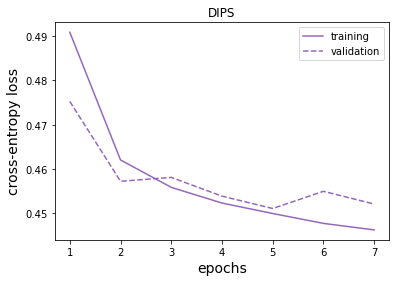

In [21]:
epochs = np.arange(1,len(dips_hist.history['loss'])+1)

plt.plot(epochs,dips_hist.history['loss'],color='hotpink',label='training')
plt.plot(epochs,dips_hist.history['val_loss'],color='hotpink',label='validation',ls='--')
plt.xlabel('epochs',fontsize=14)
plt.ylabel('cross-entropy loss',fontsize=14)
plt.legend()
plt.title('DIPS')

plt.show()

Since only 500k jets are being used in the training rn, the model might be overfitting a bit for these hyperparameters.

**Evaluate the results with a roc curve**

For this multiclass output problem, we'll combine the three class probabilities into a single discriminant.

$$D_b = \log \frac{p_b}{f_c \cdot p_c + (1 - f_c) \cdot p_l}$$

where $f_c$ is the "charm fraction" which is a parameter we choose after training the network.

For this tutorial we will set $f_c = 0.07$.


**(Warm up) question:** Will a $b$-jet have high or low values of $D_b$?

-> High values of $D_b$

What about $c$ and $l$-jets?

-> Low values of $D_b$

**Test your assumption** The code below does the roc curve calculation.

TO DO: Fill in the discriminant calculation (the line below starting with)

`disc = ...` 

In [22]:
def sigBkgEff(myModel, X_test, y_test, fc=0.07, title=''):
    '''
    Given a model, make the histograms of the model outputs to get the ROC curves.

    Input:
        myModel: A keras model
        X_test: Model inputs of the test set
        y_test: Truth labels for the test set
        fc: The amount by which to weight the c-jet prob in the disc. The
            default value of 0.07 corresponds to the fraction of c-jet bkg
            in ttbar.

    Output:
        effs: A list with 3 entries for the l, c, and b effs
    '''

    # Evaluate the performance with the ROC curves!
    predictions = myModel.predict(X_test,verbose=True)

    '''
    TO DO: Set up the discriminant function
    '''
    disc = np.log(np.divide(predictions[:,2], fc*predictions[:,1] + (1 - fc) * predictions[:,0]))
    
    # Define the min and max range for the distribution
    discMax = np.max(disc)
    discMin = np.min(disc)
    
    myRange=(discMin,discMax)
    nBins = 200

    effs = []
    for output, flavor in zip([0,1,2], ['l','c','b']):

        ix = (y_test == output)
        
        # Plot the discriminant output
        # nEntries is just a sum of the weight of each bin in the histogram.
        nEntries, edges ,_ = plt.hist(disc[ix],alpha=0.5,label=f'{flavor}-jets',
                                      bins=nBins, range=myRange, density=True, log=True)
        
        # Since high Db scores correspond to more b-like jets, compute the cummulative density function
        # from summing from high to low values, this is why we reverse the order of the bins in nEntries
        # using the "::-1" numpy indexing.
        eff = np.add.accumulate(nEntries[::-1]) / np.sum(nEntries)
        effs.append(eff)

    plt.title(title)
    plt.legend()
    plt.xlabel('$D = \ln [ p_b / (f_c p_c + (1- f_c)p_l ) ]$',fontsize=14)
    plt.ylabel('Normalized entries')
        
    return effs


In [23]:
# To draw the roc curves faster, look at a subset of the test dataset. 
nTest = 1000000

X_test = f['X_train'][:nTest]
y_test = f['y_train'][:nTest]

In [24]:
ppm_sizes_int

[50, 50, 32]

31250/31250 [==============================] - 38s 1ms/step


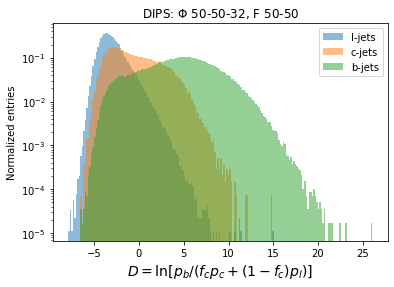

In [25]:
title = 'DIPS: $\Phi$ ' + '-'.join([str(i) for i in ppm_sizes_int])
title += ', F ' + '-'.join([str(i) for i in dense_sizes_int])

leff, ceff, beff = sigBkgEff(dips, X_test, y_test, title=title)

/tmp/ipykernel_2336/2647297232.py:3: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(beff, 1 / leff, color='C4', label='dips: l-rej')
/tmp/ipykernel_2336/2647297232.py:6: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(beff, 1 / ceff, color='C4', linestyle='--', label='dips: c-rej')
/tmp/ipykernel_2336/2647297232.py:14: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,int(2e3))


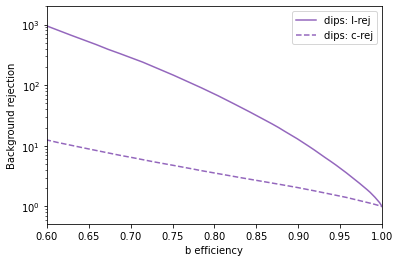

In [26]:
# l-rej
plt.figure()
plt.plot(beff, 1 / leff, color='hotpink', label='dips: l-rej')

# c-rej
plt.plot(beff, 1 / ceff, color='hotpink', linestyle='--', label='dips: c-rej')
plt.xlabel('b efficiency')
plt.ylabel('Background rejection')

plt.legend()
#plt.title(title)
plt.yscale("log")
plt.xlim(0.6,1)
plt.ylim(0,int(2e3))

plt.show()

**Step 3:** Test out other permutation invariant operations
<a name="permOps"></a>

- max
- mean

**Hint(s):** 
- Use the Sum() layer above for inspiration
- Try typing K. and press the tab completion to see what other functions are available

In [27]:
'''
Will be left blank for the students
'''

class Max(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True

    def build(self, input_shape):
        pass

    def call(self, x, mask=None):
        if mask is not None:
            x = x * K.cast(mask, K.dtype(x))[:,:,None]
        return K.max(x, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[2]

    def compute_mask(self, inputs, mask):
        return None

In [28]:
'''
Will be left blank for the students
'''

class Mean(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True

    def build(self, input_shape):
        pass

    def call(self, x, mask=None):
        if mask is not None:
            x = x * K.cast(mask, K.dtype(x))[:,:,None]
        return K.mean(x, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[2]

    def compute_mask(self, inputs, mask):
        return None

**Try training these models and see how they compare:**

It's fine to use the same hyperparameters as above for the $\Phi$ and $F$ networks to just compare the impact of the pooling operation.

In [29]:
trk_inputs = Input(shape=(maxNumTrks,nFeatures),name='Input')
masked_inputs = Masking(mask_value=0)(trk_inputs)
tdd = masked_inputs

for i, phi_nodes in enumerate(ppm_sizes_int):

    tdd = TimeDistributed(Dense(phi_nodes,activation='linear'),name=f"Phi{i}_Dense")(tdd)
    tdd = TimeDistributed(ReLU(),name=f"Phi{i}_ReLU")(tdd)

# This is where the magic happens... sum up the track features!
F = Max(name="Max")(tdd)

for j, F_nodes in enumerate(dense_sizes_int):

    F = Dense(F_nodes, activation='linear', name=f"F{j}_Dense")(F)
    F = ReLU(name=f"F{j}_ReLU")(F)

output = Dense(nClasses, activation='softmax',name="Jet_class")(F)

'''
All but the last line here will be left blank for the students
'''

dips_max = Model(inputs=trk_inputs, outputs=output)

In [30]:
dips_max.compile(loss='categorical_crossentropy', optimizer='adam',
                 metrics=['acc'])  

dips_hist_max = dips_max.fit(X_train, y_train_cat, epochs=nEpochs, 
                         batch_size=128,validation_split=0.2,
                         callbacks=[earlyStop, dips_mChkPt])

Epoch 1/7
2982/2985 [============================>.] - ETA: 0s - loss: 0.5101 - acc: 0.8251
Epoch 1: val_loss did not improve from 0.45110
2985/2985 [==============================] - 10s 3ms/step - loss: 0.5100 - acc: 0.8251 - val_loss: 0.4833 - val_acc: 0.8326
Epoch 2/7
2971/2985 [============================>.] - ETA: 0s - loss: 0.4738 - acc: 0.8360
Epoch 2: val_loss did not improve from 0.45110
2985/2985 [==============================] - 9s 3ms/step - loss: 0.4739 - acc: 0.8360 - val_loss: 0.4708 - val_acc: 0.8371
Epoch 3/7
2981/2985 [============================>.] - ETA: 0s - loss: 0.4671 - acc: 0.8379
Epoch 3: val_loss did not improve from 0.45110
2985/2985 [==============================] - 9s 3ms/step - loss: 0.4672 - acc: 0.8379 - val_loss: 0.4665 - val_acc: 0.8384
Epoch 4/7
2968/2985 [============================>.] - ETA: 0s - loss: 0.4633 - acc: 0.8392
Epoch 4: val_loss did not improve from 0.45110
2985/2985 [==============================] - 9s 3ms/step - loss: 0.4633 - 

In [31]:
trk_inputs = Input(shape=(maxNumTrks,nFeatures),name='Input')
masked_inputs = Masking(mask_value=0)(trk_inputs)
tdd = masked_inputs

for i, phi_nodes in enumerate(ppm_sizes_int):

    tdd = TimeDistributed(Dense(phi_nodes,activation='linear'),name=f"Phi{i}_Dense")(tdd)
    tdd = TimeDistributed(ReLU(),name=f"Phi{i}_ReLU")(tdd)

# This is where the magic happens... sum up the track features!
F = Mean(name="Mean")(tdd)

for j, F_nodes in enumerate(dense_sizes_int):

    F = Dense(F_nodes, activation='linear', name=f"F{j}_Dense")(F)
    F = ReLU(name=f"F{j}_ReLU")(F)

output = Dense(nClasses, activation='softmax',name="Jet_class")(F)

'''
All but the last line here will be left blank for the students
'''

dips_mean = Model(inputs=trk_inputs, outputs=output)

In [32]:
dips_mean.compile(loss='categorical_crossentropy', optimizer='adam',
                 metrics=['acc'])  

dips_hist_mean = dips_mean.fit(X_train, y_train_cat, epochs=nEpochs, 
                     batch_size=128,validation_split=0.2,
                     callbacks=[earlyStop, dips_mChkPt])

Epoch 1/7
2977/2985 [============================>.] - ETA: 0s - loss: 0.4975 - acc: 0.8279
Epoch 1: val_loss did not improve from 0.45110
2985/2985 [==============================] - 10s 3ms/step - loss: 0.4975 - acc: 0.8279 - val_loss: 0.4736 - val_acc: 0.8357
Epoch 2/7
2984/2985 [============================>.] - ETA: 0s - loss: 0.4645 - acc: 0.8389
Epoch 2: val_loss did not improve from 0.45110
2985/2985 [==============================] - 9s 3ms/step - loss: 0.4646 - acc: 0.8389 - val_loss: 0.4630 - val_acc: 0.8385
Epoch 3/7
2970/2985 [============================>.] - ETA: 0s - loss: 0.4573 - acc: 0.8412
Epoch 3: val_loss did not improve from 0.45110
2985/2985 [==============================] - 9s 3ms/step - loss: 0.4573 - acc: 0.8412 - val_loss: 0.4577 - val_acc: 0.8413
Epoch 4/7
2984/2985 [============================>.] - ETA: 0s - loss: 0.4529 - acc: 0.8421
Epoch 4: val_loss did not improve from 0.45110
2985/2985 [==============================] - 9s 3ms/step - loss: 0.4529 - 

**Which of these 3 models is doing the best?** 

Initial check: Compare the loss curves.

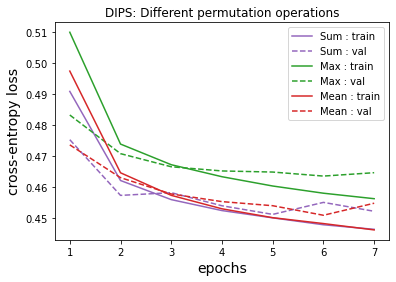

In [33]:
epochs = np.arange(1,len(dips_hist.history['loss'])+1)


for h,c,l in zip([dips_hist, dips_hist_max, dips_hist_mean],
                 ['hotpink','C2','C1'],['Sum','Max','Mean']):
    plt.plot(epochs,h.history['loss'],color=c,label=f'{l} : train')
    plt.plot(epochs,h.history['val_loss'],color=c,label=f'{l} : val',ls='--')
    
plt.xlabel('epochs',fontsize=14)
plt.ylabel('cross-entropy loss',fontsize=14)
plt.legend()
plt.title('DIPS: Different permutation operations')

plt.show()

Next: compare the roc curves on the test set

31250/31250 [==============================] - 38s 1ms/step


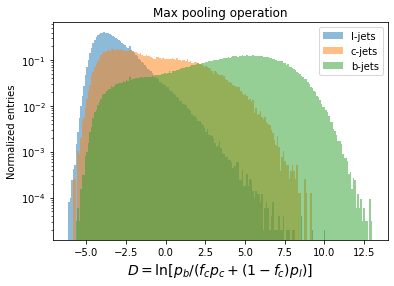

In [34]:
leff_max, ceff_max, beff_max = sigBkgEff(dips_max, X_test, y_test, 
                                         title='Max pooling operation')

31250/31250 [==============================] - 38s 1ms/step


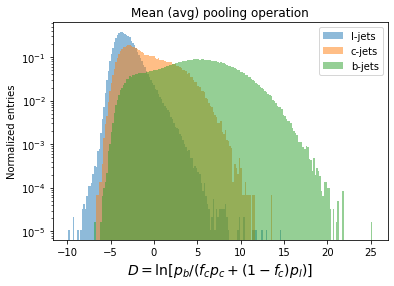

In [35]:
leff_mean, ceff_mean, beff_mean = sigBkgEff(dips_mean, X_test, y_test, 
                                            title='Mean (avg) pooling operation')

/tmp/ipykernel_2336/2327736129.py:7: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(bi, 1 / li, color=c, label=f'{l}: l-rej')
/tmp/ipykernel_2336/2327736129.py:10: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(bi, 1 / ci, color=c, linestyle='--', label=f'{l}: c-rej')
/tmp/ipykernel_2336/2327736129.py:7: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(bi, 1 / li, color=c, label=f'{l}: l-rej')
/tmp/ipykernel_2336/2327736129.py:10: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(bi, 1 / ci, color=c, linestyle='--', label=f'{l}: c-rej')
/tmp/ipykernel_2336/2327736129.py:7: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(bi, 1 / li, color=c, label=f'{l}: l-rej')
/tmp/ipykernel_2336/2327736129.py:10: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(bi, 1 / ci, color=c, linestyle='--', label=f'{l}: c-rej')
/tmp/ipykernel_2336/2327736129.py:18: UserWarning: Attempted 

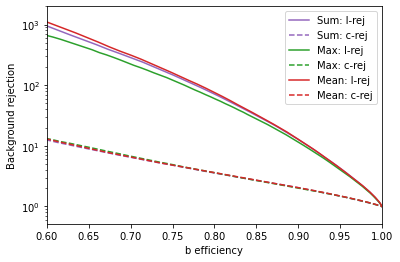

In [36]:
plt.figure()

for bi,li,ci,c, l in zip([beff,beff_max,beff_mean],[leff,leff_max,leff_mean],
                         [ceff,ceff_max,ceff_mean],['hotpink','C2','C1'],['Sum','Max','Mean']):

    # l-rej
    plt.plot(bi, 1 / li, color=c, label=f'{l}: l-rej')

    # c-rej
    plt.plot(bi, 1 / ci, color=c, linestyle='--', label=f'{l}: c-rej')
plt.xlabel('b efficiency')
plt.ylabel('Background rejection')

plt.legend()
#plt.title(title)
plt.yscale("log")
plt.xlim(0.6,1)
plt.ylim(0,int(2e3))

plt.show()

**Q1:** Which is the least performant model?

-> The Max pooling operation 

**Q2** Why might this model be doing not as good?

-> By just taking the max over the features, we're loosing information from the features for many of the jets.

**Step 4:** Test out batch norm
<a name="bn"></a>

[BatchNormalization](https://arxiv.org/abs/1502.03167) is a regularization tecnique for deep models. The key idea is that it's easier for models to train if the input are bell shaped and centered around 0 to take advantage of the non-linearity. This is why we normalize the inputs in the pre-processing, and the Batch-Normalization is a technique which normalizes the outputs from a network layer so that the next layer has nicely scaled inputs for the training. 

**Add batch norm to the model**

In [37]:
trk_inputs = Input(shape=(maxNumTrks,nFeatures),name='Input')
masked_inputs = Masking(mask_value=0)(trk_inputs)
tdd = masked_inputs

for i, phi_nodes in enumerate(ppm_sizes_int):

    tdd = TimeDistributed(Dense(phi_nodes,activation='linear'),name=f"Phi{i}_Dense")(tdd)

    # Example - how to add batch norm to the Phi network
    tdd = TimeDistributed(BatchNormalization(),name=f"Phi{i}_BatchNormalization")(tdd)
    
    tdd = TimeDistributed(ReLU(),name=f"Phi{i}_ReLU")(tdd)

# This is where the magic happens... sum up the track features!
F = Sum(name="Sum")(tdd)

for j, F_nodes in enumerate(dense_sizes_int):

    F = Dense(F_nodes, activation='linear', name=f"F{j}_Dense")(F)
    
    '''
    TO DO: Also add batch norm to the F dense network
    '''
    F = BatchNormalization(name=f"F{j}_BatchNormalization")(F)
    #raise NotImplementedError
    
    F = ReLU(name=f"F{j}_ReLU")(F)

output = Dense(nClasses, activation='softmax',name="Jet_class")(F)
dips_bn = Model(inputs=trk_inputs, outputs=output)

**Train the model**

In [38]:
dips_bn.compile(loss='categorical_crossentropy', optimizer='adam',
                 metrics=['acc'])  

dips_hist_bn = dips_bn.fit(X_train, y_train_cat, epochs=nEpochs, 
                         batch_size=128,validation_split=0.2,
                         callbacks=[earlyStop, dips_mChkPt])

Epoch 1/7
2975/2985 [============================>.] - ETA: 0s - loss: 0.4886 - acc: 0.8301
Epoch 1: val_loss did not improve from 0.45081
2985/2985 [==============================] - 17s 5ms/step - loss: 0.4885 - acc: 0.8301 - val_loss: 0.4719 - val_acc: 0.8361
Epoch 2/7
2976/2985 [============================>.] - ETA: 0s - loss: 0.4634 - acc: 0.8393
Epoch 2: val_loss did not improve from 0.45081
2985/2985 [==============================] - 15s 5ms/step - loss: 0.4634 - acc: 0.8393 - val_loss: 0.4587 - val_acc: 0.8407
Epoch 3/7
2975/2985 [============================>.] - ETA: 0s - loss: 0.4586 - acc: 0.8404
Epoch 3: val_loss did not improve from 0.45081
2985/2985 [==============================] - 15s 5ms/step - loss: 0.4586 - acc: 0.8404 - val_loss: 0.4552 - val_acc: 0.8422
Epoch 4/7
2982/2985 [============================>.] - ETA: 0s - loss: 0.4547 - acc: 0.8421
Epoch 4: val_loss did not improve from 0.45081
2985/2985 [==============================] - 15s 5ms/step - loss: 0.4547

**Compare the training curves**

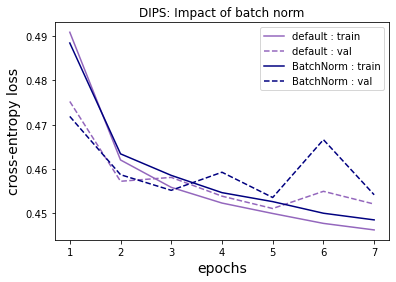

In [39]:
epochs = np.arange(1,len(dips_hist.history['loss'])+1)

for h,c,l in zip([dips_hist, dips_hist_bn],
                 ['hotpink','navy'],['default','BatchNorm']):
    plt.plot(epochs,h.history['loss'],color=c,label=f'{l} : train')
    plt.plot(epochs,h.history['val_loss'],color=c,label=f'{l} : val',ls='--')
    
plt.xlabel('epochs',fontsize=14)
plt.ylabel('cross-entropy loss',fontsize=14)
plt.legend()
plt.title('DIPS: Impact of batch norm')

plt.show()

31250/31250 [==============================] - 46s 1ms/step


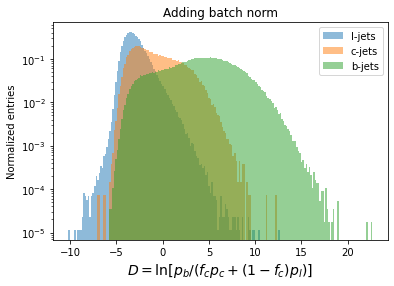

In [40]:
leff_bn, ceff_bn, beff_bn = sigBkgEff(dips_bn, X_test, y_test,  
                                      title='Adding batch norm')

In [41]:
from scipy.interpolate import pchip

/tmp/ipykernel_2336/1564174034.py:8: RuntimeWarning: divide by zero encountered in true_divide
  ax1.plot(bi, 1 / li, color=c, label=f'{l}: l-rej')
/tmp/ipykernel_2336/1564174034.py:10: RuntimeWarning: divide by zero encountered in true_divide
  ax1.plot(bi, 1 / ci, color=c, linestyle='--', label=f'{l}: c-rej')
/tmp/ipykernel_2336/1564174034.py:8: RuntimeWarning: divide by zero encountered in true_divide
  ax1.plot(bi, 1 / li, color=c, label=f'{l}: l-rej')
/tmp/ipykernel_2336/1564174034.py:10: RuntimeWarning: divide by zero encountered in true_divide
  ax1.plot(bi, 1 / ci, color=c, linestyle='--', label=f'{l}: c-rej')
/tmp/ipykernel_2336/1564174034.py:38: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_ylim(0,int(2e3))


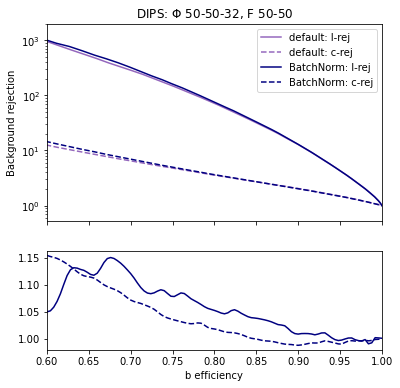

In [43]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(6,6),sharex=True,
                              gridspec_kw={'height_ratios':[2,1]})

for bi,li,ci,c, l in zip([beff,beff_bn],[leff,leff_bn],[ceff,ceff_bn],
                         ['hotpink','navy'],['default','BatchNorm']):

    # l-rej
    ax1.plot(bi, 1 / li, color=c, label=f'{l}: l-rej')
    # c-rej
    ax1.plot(bi, 1 / ci, color=c, linestyle='--', label=f'{l}: c-rej')
    
    
# Also the ratio panel
xx = np.linspace(0.6,1,101)

dx = np.concatenate((np.ones(1),np.diff(beff)))
dx_bn = np.concatenate((np.ones(1),np.diff(beff_bn)))

# l-rej
for bkg,bkg_bn, ls in zip([leff,ceff],[leff_bn,ceff_bn],['-','--']):
    
    m_num = (bkg_bn!=0) & (dx_bn>0)
    m_den = (bkg!=0) & (dx>0)
    
    f_num = pchip(beff_bn[m_num], 1/bkg_bn[m_num]) 
    f_den = pchip(beff[m_den],    1/bkg[m_den]) 

    ax2.plot(xx, f_num(xx) / f_den(xx), ls=ls, color=c)
    
ax2.set_xlabel('b efficiency')
ax1.set_ylabel('Background rejection')
ax1.set_ylabel('Background rejection')

ax1.legend()
ax1.set_title(title)
ax1.set_yscale("log")
ax1.set_xlim(0.6,1)
ax1.set_ylim(0,int(2e3))

plt.show()

**Look at the activation functions**

Let's start off by looking at the first layer of the $\Phi$ network.

In [170]:
phi_i = 0

ni = 10000

In [171]:
func = K.function([dips.get_layer('Input').input], dips.get_layer(f'Phi{phi_i}_Dense').output)
act = func([X_test[:ni]])  

In [172]:
'''
To do - fill in to get the activations from the batch norm trained network
'''

func = K.function([dips_bn.get_layer('Input').input], dips_bn.get_layer(f'Phi{phi_i}_Dense').output)
bnIn = func([X_test[:ni]])  

func = K.function([dips_bn.get_layer('Input').input], dips_bn.get_layer(f'Phi{phi_i}_BatchNormalization').output)
bnOut = func([X_test[:ni]])  

To avoid evaluating the activations that _don't_ have any tracks, need to define the track mask

In [173]:
tmask = ~np.all(X_test[:ni]==0, axis=-1) # False for a padded track

In [174]:
tmask.shape

(10000, 25)

This track mask has shape (nJets, maxNumTrks)

In [175]:
tmask[:2]

array([[ True,  True,  True,  True,  True,  True, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False],
       [ True,  True,  True,  True,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False]])

And looking at the first two jets we can see:
- The first jet has 6 tracks
- The 2nd jet has 5 tracks

In [176]:
from matplotlib import transforms

def rainbow_text(x,y,ls,lc,yoffset=.75,ax=None,**kw):
    '''
    Take a list of strings ``ls`` and colors ``lc`` and place them next to each
    other, with text ls[i] being shown in color lc[i].

    This example shows how to do both vertical and horizontal text, and will
    pass all keyword arguments to plt.text, so you can set the font size,
    family, etc.
    '''

    if ax is None:
        ax=plt.gca()

    t = ax.transData
    fig = plt.gcf()

    #horizontal version
    for s,c in zip(ls,lc):
        text = plt.text(x,y," "+s,color=c, transform=t, **kw)
        text.draw(fig.canvas.get_renderer())
        ex = text.get_window_extent()
        t = transforms.offset_copy(text._transform, y=-yoffset*ex.height, units='dots')

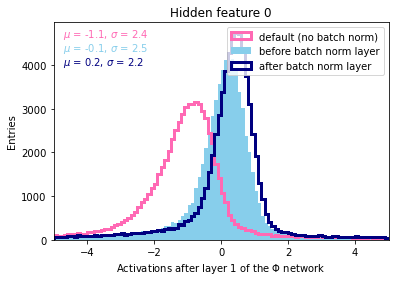

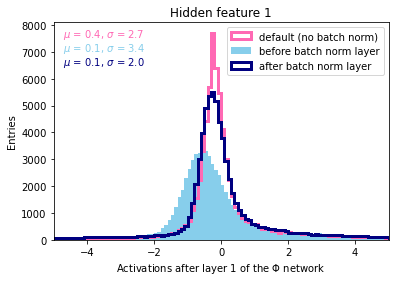

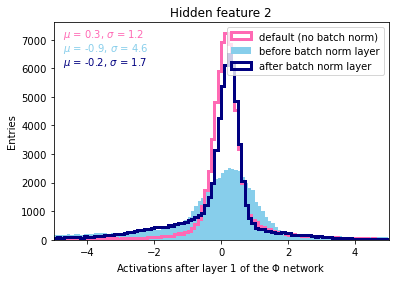

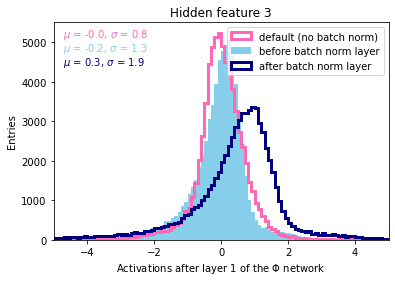

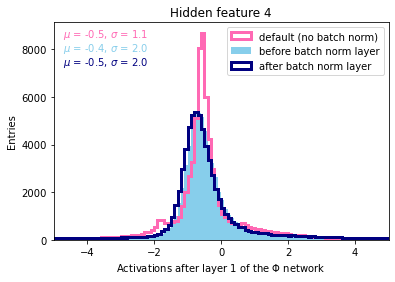

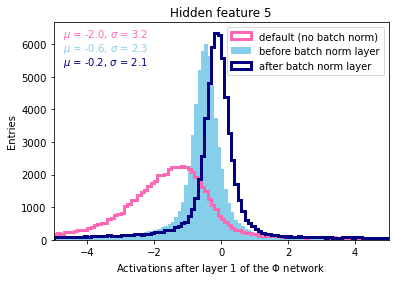

In [177]:
for feat in range(6):

    nbins=100
    r=(-5,5)

    plt.hist(act[:,:,feat][tmask],nbins,r,color='hotpink',lw=3,label='default (no batch norm)',histtype='step')
    
    plt.hist(bnIn[:,:,feat][tmask],nbins,r,color='skyblue',label='before batch norm layer')
    plt.hist(bnOut[:,:,feat][tmask],nbins,r,color='navy',lw=3,
             label='after batch norm layer',histtype='step')
    
    '''
    Add text to the plot to track the mean + std
    '''
    lc = ['hotpink','skyblue','navy']
    ls = []
    for o in [act,bnIn,bnOut]:
        oi = o[:,:,feat][tmask]
    
        ls.append(f'$\mu$ = {oi.mean():.1f}, $\sigma$ = {oi.std():.1f}')
    
    _, ymax = plt.ylim()
    rainbow_text(-4.8,.98*ymax,ls,lc, ha='left',va='top',yoffset=1)
    
    plt.xlim(r)
    plt.legend(loc='upper right')
    plt.xlabel(f'Activations after layer {phi_i+1} of the $\Phi$ network')
    plt.ylabel('Entries')
    plt.title(f'Hidden feature {feat}')
    plt.show()

**Also look at activations in the F network**

Now that we have the branches for the (pieces) of the network setup - evaluate them to get the corresponding activations.

In [178]:
ni = 100000

F_j = 0

In [179]:
func = K.function([dips.get_layer('Input').input], dips.get_layer(f'F{F_j}_Dense').output)
act = func([X_test[:ni]])  

In [180]:
'''
TO DO - fill in to get the activations fro the batch norm network
'''

func = K.function([dips_bn.get_layer('Input').input], 
                  dips_bn.get_layer(f'F{F_j}_Dense').output)
bnIn = func([X_test[:ni]])  

func = K.function([dips_bn.get_layer('Input').input], 
                  dips_bn.get_layer(f'F{F_j}_BatchNormalization').output)
bnOut = func([X_test[:ni]])  

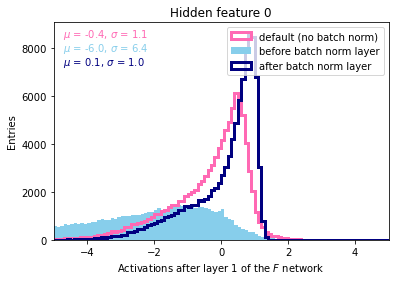

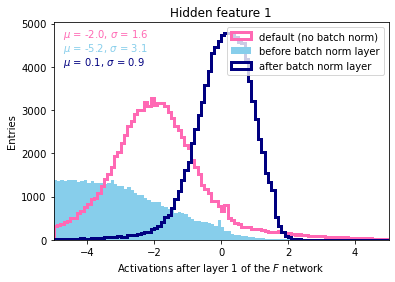

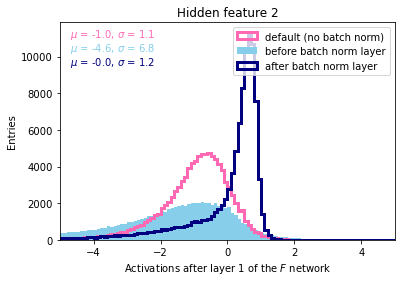

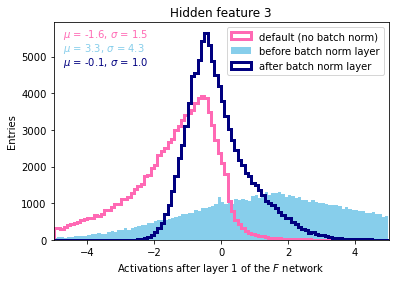

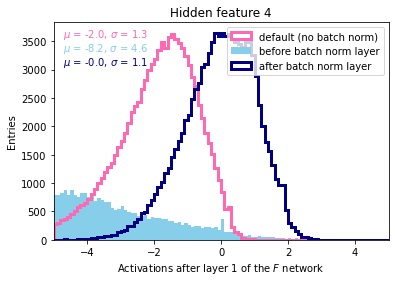

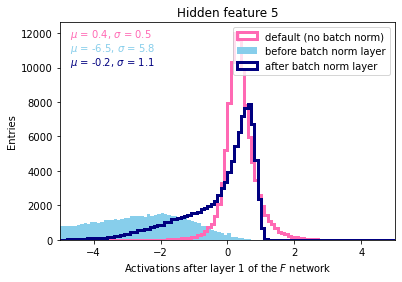

In [181]:
for feat in range(6):

    nbins=100
    r=(-5,5)

    plt.hist(act[:,feat],nbins,r,color='hotpink',lw=3,
             label='default (no batch norm)',histtype='step')
    
    plt.hist(bnIn[:,feat],nbins,r,color='skyblue',label='before batch norm layer')
    plt.hist(bnOut[:,feat],nbins,r,color='navy',lw=3,
             label='after batch norm layer',histtype='step')
    
    '''
    Add text to the plot to track the mean + std
    '''
    lc = ['hotpink','skyblue','navy']
    ls = []
    for o in [act,bnIn,bnOut]:
        oi = o[:,feat]
        ls.append(f'$\mu$ = {oi.mean():.1f}, $\sigma$ = {oi.std():.1f}')
    
    _, ymax = plt.ylim()
    rainbow_text(-4.8,.98*ymax,ls,lc, ha='left',va='top',yoffset=1)
    
    plt.xlim(r)
    plt.legend(loc='upper right')
    plt.xlabel(f'Activations after layer {F_j+1} of the $F$ network')
    plt.ylabel('Entries')
    plt.title(f'Hidden feature {feat}')
    plt.show()

And... that's it for today!!


Just as a reminder what we learned in this tutorial:

1. How to setup and train a deep sets model for a multi-class classification problem
2. To boost our understanding - we tested some other permutation invariant operations
3. We checked the impact of batch norm on the models and examined the activations

But the biggest take away is... hopefully you're convinced that Deep Sets is a fast and easy model to get running - and inspired to test it out on some of your ATLAS research problems :) 